<h1><center>Predicting significant wave height using machine learning</center></h1>

<img src="https://www.pacioos.hawaii.edu/wp-content/uploads/2018/05/news-kalaeloa-barbers-point-wave-buoy-672x350.jpg" alt="Wave buoy image" title="" />

This notebook present code example to model signficant wave height using **two machine learning models**:
1. LSTM model 
2. CNN model

We used the data of the buoy station number <font color=blue>6400045</font>, downloaded from the European marine observation and data network website ("https://www.emodnet-physics.eu/Map/DefaultMap.aspx")


You will need to install the common data manipulation library **(pandas, NumPy)**, **Keras** for the machine learning part, and **Altair** for data visualization

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import altair as alt
from vega_datasets import data

import datetime

In [2]:
#load the data
rawdata = pd.read_excel("All_data_6400045.xlsx", header=0, index_col=0)
rawdata

,DEPTH,ATMS,ATMS_QC,DEWT,DEWT_QC,DRYT,DRYT_QC,LATITUDE,LONGITUDE,POSITION_QC,...,TEMP_QC,TIME_QC,VHM0,VHM0_QC,VTZA,VTZA_QC,WDIR,WDIR_QC,WSPD,WSPD_QC
TIME,,,,,,,,,,,,,,,,,,,,,
01/01/2015 00:00:00:000,0,996.1,1,3.5,1,8.1,1,59.099998,-11.401,1,...,-127,1,4.9,1,8,1,--,9,--,9
01/01/2015 01:00:00:000,0,997.3,1,4.7,1,8.2,1,59.099998,-11.401,1,...,-127,1,5.8,1,8,1,--,9,--,9
01/01/2015 02:00:00:000,0,998.5,1,2.2,1,7.9,1,59.099998,-11.401,1,...,-127,1,6,1,8,1,--,9,--,9
01/01/2015 03:00:00:000,0,999.3,1,3.7,1,7.9,1,59.099998,-11.401,1,...,-127,1,5.8,1,8,1,--,9,--,9
01/01/2015 04:00:00:000,0,999.5,1,0.6,1,8,1,59.099998,-11.401,1,...,-127,1,5.8,1,8,1,--,9,--,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31/10/2020 19:00:00:000,0,978,1,--,9,8.6,1,59.099998,-11.401,1,...,-127,1,4.9,1,8,1,290,1,16,1
31/10/2020 20:00:00:000,0,979.6,1,--,9,8,1,59.099998,-11.401,1,...,-127,1,4.5,1,8,1,270,1,12.4,1
31/10/2020 21:00:00:000,0,980.6,1,--,9,8.3,1,59.099998,-11.401,1,...,-127,1,4.2,1,7,1,270,1,12.9,1


<h2>In this example, we are just gonna use wind speed and wind direction as input to the model</h2>

In [3]:
data = rawdata[["VHM0", "WDIR", "WSPD"]]
data

,VHM0,WDIR,WSPD
TIME,,,
01/01/2015 00:00:00:000,4.9,--,--
01/01/2015 01:00:00:000,5.8,--,--
01/01/2015 02:00:00:000,6,--,--
01/01/2015 03:00:00:000,5.8,--,--
01/01/2015 04:00:00:000,5.8,--,--
...,...,...,...
31/10/2020 19:00:00:000,4.9,290,16
31/10/2020 20:00:00:000,4.5,270,12.4
31/10/2020 21:00:00:000,4.2,270,12.9


In [4]:
#We need to convert the type of the data from None to numeric and replace the "--" characters with Nan values
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

<ipython-input-4-67e2378ca6f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = pd.to_numeric(data[col], errors='coerce')


In [5]:
data

,VHM0,WDIR,WSPD
TIME,,,
01/01/2015 00:00:00:000,4.9,NaN,NaN
01/01/2015 01:00:00:000,5.8,NaN,NaN
01/01/2015 02:00:00:000,6.0,NaN,NaN
01/01/2015 03:00:00:000,5.8,NaN,NaN
01/01/2015 04:00:00:000,5.8,NaN,NaN
...,...,...,...
31/10/2020 19:00:00:000,4.9,290.0,16.0
31/10/2020 20:00:00:000,4.5,270.0,12.4
31/10/2020 21:00:00:000,4.2,270.0,12.9


# Data visualization using Altair

We are gonna create a date column to plot the data it using the Altair visualization library

In [6]:
time = list(data.index.values)
for i in range(len(time)):
    time[i] = datetime.datetime.strptime(time[i][:19], '%d/%m/%Y %H:%M:%S')

In [7]:
data["Date"] = time

<ipython-input-7-792733578a69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = time


In [8]:
alt.data_transformers.enable('json')
alt.Chart(data, title="Evolution of significant wave height over time").mark_line(point=True).encode(
    x='Date',
    y='VHM0',
    tooltip='Date'
).properties(
    width=1000,
    height=400
)

alt.Chart(...)

In [9]:
alt.data_transformers.enable('json')
alt.Chart(data).mark_bar().encode(
    alt.X("VHM0", bin=True),
    y='count()',
).properties(
    width=500,
    height=400
)

alt.Chart(...)

In [10]:
alt.data_transformers.enable('json')
alt.Chart(data, title="Evolution of Wind speed over time").mark_line(point=True).encode(
    x='Date',
    y='WSPD',
    tooltip='Date'
).properties(
    width=1000,
    height=400
)

alt.Chart(...)

<h2>We can observe that there's an extreme max value on <font color=blue>march 13th 2008</font> </h2>

In [11]:
data.loc[data[data["WSPD"] >30].index, "WSPD"] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
#verification that the observation was deleted
data.loc[data[data["WSPD"] >30].index, "WSPD"]

Series([], Name: WSPD, dtype: float64)

In [13]:
#We can see that the observations was deleted
alt.data_transformers.enable('json')
alt.Chart(data, title="Evolution of wind speed over time").mark_line(point=True).encode(
    x='Date',
    y='WSPD',
    tooltip='Date'
).properties(
    width=1000,
    height=400
)

alt.Chart(...)

<h2> Data preparation</h2>

In [14]:
#We are gonna drop date because we don't need it now
data = data.drop("Date",axis=1)
data

,VHM0,WDIR,WSPD
TIME,,,
01/01/2015 00:00:00:000,4.9,NaN,NaN
01/01/2015 01:00:00:000,5.8,NaN,NaN
01/01/2015 02:00:00:000,6.0,NaN,NaN
01/01/2015 03:00:00:000,5.8,NaN,NaN
01/01/2015 04:00:00:000,5.8,NaN,NaN
...,...,...,...
31/10/2020 19:00:00:000,4.9,290.0,16.0
31/10/2020 20:00:00:000,4.5,270.0,12.4
31/10/2020 21:00:00:000,4.2,270.0,12.9


In [15]:
#Scale the data using minmax scaling
scaler = MinMaxScaler(feature_range=(0,1))
data = data.to_numpy()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=["VHM0","WDIR","WSPD"])
data

,VHM0,WDIR,WSPD
0,0.283133,NaN,NaN
1,0.337349,NaN,NaN
2,0.349398,NaN,NaN
3,0.337349,NaN,NaN
4,0.337349,NaN,NaN
...,...,...,...
51139,0.283133,0.800000,0.589354
51140,0.259036,0.742857,0.452471
51141,0.240964,0.742857,0.471483
51142,0.253012,0.714286,0.391635


<h2>In our model, we are gonna use the previous values of significant wave height measured to predict the next value</h2>

In [16]:
#So we are gonna shift the column to add the previous values to the model
data["VHM0 t-1"] = data["VHM0"].shift()
data

,VHM0,WDIR,WSPD,VHM0 t-1
0,0.283133,NaN,NaN,NaN
1,0.337349,NaN,NaN,0.283133
2,0.349398,NaN,NaN,0.337349
3,0.337349,NaN,NaN,0.349398
4,0.337349,NaN,NaN,0.337349
...,...,...,...,...
51139,0.283133,0.800000,0.589354,0.265060
51140,0.259036,0.742857,0.452471,0.283133
51141,0.240964,0.742857,0.471483,0.259036
51142,0.253012,0.714286,0.391635,0.240964


<h3>The input of the LSTM model must be three dimensionnal, reprsenting respectively:</h3>

1. the Samples
2. the time steps 
3. Features 

<h3>The next function is used to prepare and reshape data to be used in the LSTM model.</h3>

In [17]:
def data_prep(data, lag, X_col, y_col):
    #data---type: numpy 2d array -----def: is the data used
    #lag---type: int-------def:  represent the the time steps 
    #X_col----type: list,--------def: represente the index of the columns used as input in the model
    #y_col----type: list,--------def: represente the index of the columns used as output in the model
    X_train = []
    y_train = []
    for i in range(lag, int(len(data))):
        X_train.append(data[i-lag:i, X_col])
        y_train.append(data[i-1, y_col])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(X_col)))
    return [X_train, y_train]

In [18]:
#the time step used is 10 previous hours of data measured
X, y = data_prep(data.to_numpy(), lag=10, X_col=[1,2,3], y_col=[0])

In [19]:
#Data verification
X[:10]

array([[[       nan,        nan,        nan],
        [       nan,        nan, 0.28313253],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.34939759],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.31325301],
        [       nan,        nan, 0.3253012 ]],

       [[       nan,        nan, 0.28313253],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.34939759],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.3373494 ],
        [       nan,        nan, 0.31325301],
        [       nan,        nan, 0.3253012 ],
        [       nan,        nan, 0.31325301]],

       [[       nan,        nan, 0.3373494 ],
        [       nan,        na

In [20]:
#We need to reshape the y array
y = y.reshape(len(y),)
#Data verification
y[:10]

array([0.31325301, 0.30722892, 0.31325301, 0.30722892, 0.31325301,
       0.29518072, 0.29518072, 0.27710843, 0.27710843, 0.24096386])

In [21]:
#Data verification
data.head(15)

,VHM0,WDIR,WSPD,VHM0 t-1
0,0.283133,NaN,NaN,NaN
1,0.337349,NaN,NaN,0.283133
2,0.349398,NaN,NaN,0.337349
3,0.337349,NaN,NaN,0.349398
4,0.337349,NaN,NaN,0.337349
5,0.337349,NaN,NaN,0.337349
6,0.337349,NaN,NaN,0.337349
7,0.313253,NaN,NaN,0.337349
8,0.325301,NaN,NaN,0.313253
9,0.313253,NaN,NaN,0.325301


In [22]:
#we need to get the corresponding time to plot it in Altair in the next sections
time_model = np.array(time[10:])

<h3>The Next cell present how to find and delete the nan values in the input and output numpy arrays</h3>

In [23]:
#Determine where there's a nan value in input or output (if any of [x1, x2, ...] == nan np.isnan == True)
x_nan_index = np.isnan(X).any(axis=1)
x_nan_index = x_nan_index[:,0] | x_nan_index[:,1] |  x_nan_index[:,2]
y_nan_index = np.isnan(y)
#Apply the OR operation on the two index
train_index = x_nan_index | y_nan_index
#Get the values or vectors where's there's no nan values
X = X[~train_index]
y = y[~train_index]
time_model = time_model[~train_index]

In [24]:
#Now we split the data into train and test datasets, and also split the time array
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time_model, test_size=0.33, random_state=77)

<h1><center>Modeliing using LSTM</center></h1>

<img src="https://miro.medium.com/max/594/0*dhz-SOm-BW3rTEYa" alt="LSTM model image" title="" />

<h3> <center>In the next cells, we are gonna create and train out LSTM model and check its performance</center></h3>
<h4> We would like to point out that the architecture of the model is not optimized, and there's overfitting that can be avoided by analyzing more efficiently the data and maybe split the train, validation, and test datasets manually</h4>

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf

In [26]:
#Define the structure of the model
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 3)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


history = model.fit(X_train, y_train, epochs =100, batch_size = 1000, validation_split=0.3)

Epoch 1/100
14/14 [==============================] - 3s 216ms/step - loss: 0.0145 - val_loss: 0.0073
Epoch 2/100
14/14 [==============================] - 2s 138ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 3/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 4/100
14/14 [==============================] - 2s 135ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/100
14/14 [==============================] - 2s 144ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 6/100
14/14 [==============================] - 2s 154ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 7/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/100
14/14 [==============================] - 2s 136ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/100
14/14 [==============================] - 2s 120ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 10/100
14/14 [==============================] - 2s 124ms/step - loss: 0.0017 - val_lo

14/14 [==============================] - 2s 122ms/step - loss: 6.5474e-04 - val_loss: 4.3995e-04
Epoch 78/100
14/14 [==============================] - 2s 150ms/step - loss: 6.5247e-04 - val_loss: 4.3905e-04
Epoch 79/100
14/14 [==============================] - 2s 132ms/step - loss: 6.2948e-04 - val_loss: 4.4280e-04
Epoch 80/100
14/14 [==============================] - 2s 126ms/step - loss: 6.2338e-04 - val_loss: 4.3353e-04
Epoch 81/100
14/14 [==============================] - 2s 136ms/step - loss: 6.4824e-04 - val_loss: 4.3898e-04
Epoch 82/100
14/14 [==============================] - 2s 121ms/step - loss: 6.3096e-04 - val_loss: 4.6313e-04
Epoch 83/100
14/14 [==============================] - 2s 125ms/step - loss: 6.3471e-04 - val_loss: 4.3040e-04
Epoch 84/100
14/14 [==============================] - 2s 144ms/step - loss: 6.2982e-04 - val_loss: 4.3225e-04
Epoch 85/100
14/14 [==============================] - 2s 125ms/step - loss: 6.1191e-04 - val_loss: 4.4276e-04
Epoch 86/100
14/14 [===

In [27]:
#checking the performance of the model on the training period
preds = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, preds))
r2 = r2_score(y_train, preds)
print('results for calibration \n')
print("RMSE: %f" % (rmse))
print("R²: %f" % (r2))

results for calibration 

RMSE: 0.021063
R²: 0.962032


In [28]:
#checking the performance of the model on the testing period
preds_test = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_test))
r2 = r2_score(y_test, preds_test)
print('results for testing \n')
print("RMSE: %f" % (rmse))
print("R²: %f" % (r2))

results for testing 

RMSE: 0.020382
R²: 0.964017


<h3> We can see that the model have a great performance</h3>

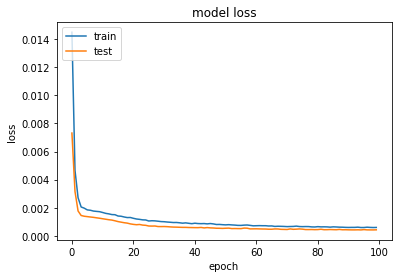

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h2><center> Training Part</center></h2>

In [30]:
#We create a dataframe in order to plot the evolution of the predicted and the observed values of the training period
train_to_plot = pd.DataFrame({"y_true": y_train,
                 "y_pred" : preds.reshape(len(preds)),
                 "date" : time_train})
train_to_plot

,y_true,y_pred,date
0,0.162651,0.173820,2019-10-12 10:00:00
1,0.126506,0.137244,2019-09-20 06:00:00
2,0.054217,0.059848,2019-07-20 04:00:00
3,0.084337,0.082293,2017-08-15 00:00:00
4,0.096386,0.100112,2017-09-21 16:00:00
...,...,...,...
19867,0.042169,0.045901,2019-07-12 02:00:00
19868,0.054217,0.052134,2020-06-18 12:00:00
19869,0.090361,0.096754,2020-08-28 19:00:00
19870,0.403614,0.410443,2018-01-03 20:00:00


In [31]:
#Q-Q plot of the training period
alt.data_transformers.enable('json')
alt.Chart(train_to_plot, title="Q-Q plot of the LSTM model (training period)").mark_point().encode(
    x='y_true',
    y='y_pred',
    tooltip='date'
).properties(
    width=400,
    height=400
)

alt.Chart(...)

<h3>We can observe that some values were not predicted very well, we recommend the potential users to check the data</h3>

In [32]:
#Plotting the evolution of predicted and observed values over time for the traiing period
alt.data_transformers.enable('json')
alt.Chart(pd.melt(train_to_plot, id_vars=['date'], value_vars=["y_true","y_pred"],
        var_name='categorie', value_name='value'), title="Evolution of the predicted and the observed values(training period)"
         ).mark_circle().encode(
    x='date',
    y='value',
    color='categorie',
    tooltip='date'
).properties(
    width=1200,
    height=400
)

alt.Chart(...)

<h2><center> Testing Part</center></h2>

In [33]:
#We create a dataframe in order to plot the evolution of the predicted and the observed values of the testing period
test_to_plot = pd.DataFrame({"y_true": y_test,
                 "y_pred" : preds_test.reshape(len(preds_test)),
                 "date" : time_test})
test_to_plot

,y_true,y_pred,date
0,0.126506,0.120690,2020-05-29 17:00:00
1,0.180723,0.173901,2019-04-29 14:00:00
2,0.228916,0.253908,2016-11-09 12:00:00
3,0.156627,0.174261,2018-05-13 11:00:00
4,0.198795,0.216572,2019-01-31 01:00:00
...,...,...,...
9783,0.090361,0.082162,2020-05-31 07:00:00
9784,0.162651,0.157590,2019-10-19 20:00:00
9785,0.198795,0.219600,2016-09-21 06:00:00
9786,0.222892,0.226393,2018-12-17 12:00:00


In [34]:
#Q-Q plot of the testing period
alt.data_transformers.enable('json')
alt.Chart(test_to_plot, title="Q-Q plot of the LSTM model (testing period)").mark_point().encode(
    x='y_true',
    y='y_pred',
    tooltip='date'
).properties(
    width=400,
    height=400
)

alt.Chart(...)

In [35]:
#Plotting the evolution of predicted and observed values over time for the traiing period
alt.data_transformers.enable('json')
alt.Chart(pd.melt(test_to_plot, id_vars=['date'], value_vars=["y_true","y_pred"],
        var_name='categorie', value_name='value'), title="Evolution of the predicted and the observed values(testing period)"
         ).mark_circle().encode(
    x='date',
    y='value',
    color='categorie',
    tooltip='date'
).properties(
    width=1200,
    height=400
)

alt.Chart(...)

<h1><center>Modeliing using CNN</center></h1>

<img src="https://www.aimspress.com/aimspress-data/mbe/2021/1/PIC/mbe-18-01-022-g004.jpg" alt="CNN for time series image" title="" />

<h3> <center>In the next cells, we are gonna create and train our CNN model and check its performance</center></h3>
<h4> We would like to point out that the architecture of the model is not optimized, and there's overfitting that can be avoided by analyzing more efficiently the data and maybe split the train, validation, and test datasets manually</h4>

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf

In [37]:
#Define the structure of the model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha=0.3), input_shape=(X_test.shape[1], 3)))
model.add(MaxPooling1D(pool_size=2, padding='SAME'))

model.add(Flatten())

model.add(Dense(100, activation='elu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs = 150, batch_size = 1000, validation_split=0.3)

Epoch 1/150
14/14 [==============================] - 0s 12ms/step - loss: 0.0232 - val_loss: 0.0042
Epoch 2/150
14/14 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0021
Epoch 3/150
14/14 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0015
Epoch 4/150
14/14 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 5/150
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 9.4970e-04
Epoch 6/150
14/14 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 8.7977e-04
Epoch 7/150
14/14 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 7.9239e-04
Epoch 8/150
14/14 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 7.4319e-04
Epoch 9/150
14/14 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 6.9912e-04
Epoch 10/150
14/14 [==============================] - 0s 5ms/step - loss: 0.0018 - val_l

Epoch 78/150
14/14 [==============================] - 0s 7ms/step - loss: 6.2549e-04 - val_loss: 4.0216e-04
Epoch 79/150
14/14 [==============================] - 0s 6ms/step - loss: 6.2108e-04 - val_loss: 3.9987e-04
Epoch 80/150
14/14 [==============================] - 0s 6ms/step - loss: 6.1202e-04 - val_loss: 3.9819e-04
Epoch 81/150
14/14 [==============================] - 0s 5ms/step - loss: 6.1381e-04 - val_loss: 3.9863e-04
Epoch 82/150
14/14 [==============================] - 0s 5ms/step - loss: 6.0735e-04 - val_loss: 4.0085e-04
Epoch 83/150
14/14 [==============================] - 0s 5ms/step - loss: 6.1442e-04 - val_loss: 4.0975e-04
Epoch 84/150
14/14 [==============================] - 0s 5ms/step - loss: 6.1304e-04 - val_loss: 3.9551e-04
Epoch 85/150
14/14 [==============================] - 0s 5ms/step - loss: 6.2106e-04 - val_loss: 3.9427e-04
Epoch 86/150
14/14 [==============================] - 0s 5ms/step - loss: 6.1475e-04 - val_loss: 3.9375e-04
Epoch 87/150
14/14 [========

In [38]:
#checking the performance of the model on the training period
preds = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, preds))
r2 = r2_score(y_train, preds)
print('results for calibration \n')
print("RMSE: %f" % (rmse))
print("R²: %f" % (r2))

results for calibration 

RMSE: 0.020153
R²: 0.965241


In [39]:
#checking the performance of the model on the testing period
preds_test = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds_test))
r2 = r2_score(y_test, preds_test)
print('results for testing \n')
print("RMSE: %f" % (rmse))
print("R²: %f" % (r2))

results for testing 

RMSE: 0.019592
R²: 0.966750


<h3> We can see that the model have a great performance</h3>
<h3>We recommend the potential users to use the CNN instead of LSTM if the performance is the same due to the less computation time</h3>

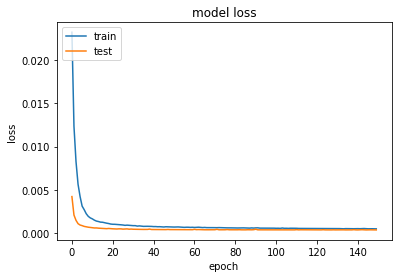

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h2><center> Training Part</center></h2>

In [41]:
#We create a dataframe in order to plot the evolution of the predicted and the observed values of the training period
train_to_plot = pd.DataFrame({"y_true": y_train,
                 "y_pred" : preds.reshape(len(preds)),
                 "date" : time_train})
train_to_plot

,y_true,y_pred,date
0,0.162651,0.175427,2019-10-12 10:00:00
1,0.126506,0.142565,2019-09-20 06:00:00
2,0.054217,0.049847,2019-07-20 04:00:00
3,0.084337,0.086754,2017-08-15 00:00:00
4,0.096386,0.096116,2017-09-21 16:00:00
...,...,...,...
19867,0.042169,0.050508,2019-07-12 02:00:00
19868,0.054217,0.051550,2020-06-18 12:00:00
19869,0.090361,0.097209,2020-08-28 19:00:00
19870,0.403614,0.420292,2018-01-03 20:00:00


In [42]:
#Q-Q plot of the training period
alt.data_transformers.enable('json')
alt.Chart(train_to_plot, title="Q-Q plot of the CNN model (training period)").mark_point().encode(
    x='y_true',
    y='y_pred',
    tooltip='date'
).properties(
    width=400,
    height=400
)

alt.Chart(...)

<h3> We can observe that there are also (maybe the same observations as in the LSTM section) some values that were not predicted very well, we recommend the potential users to check the data</h3>

In [43]:
#Plotting the evolution of predicted and observed values over time for the training period
alt.data_transformers.enable('json')
alt.Chart(pd.melt(train_to_plot, id_vars=['date'], value_vars=["y_true","y_pred"],
        var_name='categorie', value_name='value'), title="Evolution of the predicted and the observed values(training period)"
         ).mark_circle().encode(
    x='date',
    y='value',
    color='categorie',
    tooltip='date'
).properties(
    width=1200,
    height=400
)

alt.Chart(...)

<h2><center> Testing Part</center></h2>

In [44]:
#We create a dataframe in order to plot the evolution of the predicted and the observed values of the testing period
test_to_plot = pd.DataFrame({"y_true": y_test,
                 "y_pred" : preds_test.reshape(len(preds_test)),
                 "date" : time_test})
test_to_plot

,y_true,y_pred,date
0,0.126506,0.119993,2020-05-29 17:00:00
1,0.180723,0.171276,2019-04-29 14:00:00
2,0.228916,0.252227,2016-11-09 12:00:00
3,0.156627,0.172579,2018-05-13 11:00:00
4,0.198795,0.199880,2019-01-31 01:00:00
...,...,...,...
9783,0.090361,0.088489,2020-05-31 07:00:00
9784,0.162651,0.153468,2019-10-19 20:00:00
9785,0.198795,0.214357,2016-09-21 06:00:00
9786,0.222892,0.229201,2018-12-17 12:00:00


In [45]:
#Q-Q plot of the testing period
alt.data_transformers.enable('json')
alt.Chart(test_to_plot, title="Q-Q plot of the CNN model (training period)").mark_point().encode(
    x='y_true',
    y='y_pred',
    tooltip='date'
).properties(
    width=400,
    height=400
)

alt.Chart(...)

In [46]:
#Plotting the evolution of predicted and observed values over time for the training period
alt.data_transformers.enable('json')
alt.Chart(pd.melt(test_to_plot, id_vars=['date'], value_vars=["y_true","y_pred"],
        var_name='categorie', value_name='value'), title="Evolution of the predicted and the observed values(training period)"
         ).mark_circle().encode(
    x='date',
    y='value',
    color='categorie',
    tooltip='date'
).properties(
    width=1200,
    height=400
)

alt.Chart(...)